In [1]:
import importlib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from math import nan
import scipy.stats as stats
import matplotlib as mpl

from CASutils import calendar_utils as cal
from CASutils import shapefile_utils as shp
from CASutils import averaging_utils as avg

In [2]:
pathout="/project/cas/islas/python_savs/DTF/prelim/CMIP6/"

In [3]:
plotpath="/project/cas/islas/python_plots/DTF/prelim/CMIP6/"

In [4]:
# model info
cmip6models = pd.read_csv('/home/islas/python/DTF/DATA_SORT/VPD/cmip6csvinfo.csv')
models = cmip6models['Model']
nmems = cmip6models['Nmempast']
nmemmax = np.max(cmip6models['Nmempast'])

In [4]:
###NOTE - only need to run this once if you save the file.  It takes a while...
# Reading in the vapor pressure data and calculating the area average over the southwest.
# saving it as a netcdf for later use
cmip6models = pd.read_csv('/home/islas/python/DTF/DATA_SORT/VPD/cmip6csvinfo.csv')
models = cmip6models['Model']
nmems = cmip6models['Nmempast']
nmemmax = np.max(cmip6models['Nmempast'])

datpath="/project/cas/islas/python_savs/DTF/DATA_SORT/VPD/CMIP6/"

# Generate mask for the southwest
dat = xr.open_dataset('/project/cas/islas/python_savs/DTF/DATA_SORT/VPD/CMIP6/VPD_ACCESS-CM2.nc')
shpfile="/project/cas/islas/shapefiles/usa/gadm36_USA_1.shp"
masksouthwest = shp.maskgen(shpfile, dat, ['California','Nevada','Utah','Arizona','New Mexico','Colorado'])

for index, modname in models.iteritems():
    print(modname)
    nmemsp = cmip6models.loc[index, "Nmempast"]
    dat = xr.open_dataset(datpath+'VPD_'+modname+'.nc')
    
    dat_sw = avg.cosweightlonlat(dat*masksouthwest, 0, 360, -90, 90)
    
    if (index == 0):
        vpd_sw = xr.DataArray(np.zeros([models.size, nmemmax, dat.time.size]), dims=['model','member','time'],
                             coords=[models, np.arange(1,nmemmax+1,1), dat.time], name='vpd_sw')
        vp_sw = xr.DataArray(np.zeros([models.size, nmemmax, dat.time.size]), dims=['model','member','time'],
                             coords=[models, np.arange(1,nmemmax+1,1), dat.time], name='vp_sw')
        svp_sw = xr.DataArray(np.zeros([models.size, nmemmax, dat.time.size]), dims=['model','member','time'],
                             coords=[models, np.arange(1,nmemmax+1,1), dat.time], name='svp_sw')
        
    vpd_sw[index,0:nmemsp,:] = np.array(dat_sw.vpd)
    vp_sw[index,0:nmemsp,:] = np.array(dat_sw.vp)
    svp_sw[index,0:nmemsp,:] = np.array(dat_sw.svp)

vpd_sw.to_netcdf(pathout+"vpd_monthly_cmip6.nc")
vp_sw.to_netcdf(pathout+"vpd_monthly_cmip6.nc", mode="a")
svp_sw.to_netcdf(pathout+"vpd_monthly_cmip6.nc", mode="a")

In [5]:
###!!! Run this if you've already run the cell above and shut down the notebook, to read the vpd data back in
data = xr.open_dataset(pathout+"vpd_monthly_cmip6.nc")
vpd_sw = data.vpd_sw
vp_sw = data.vp_sw
svp_sw = data.svp_sw
models = data.model

In [6]:
# Calculate the annual mean
vpd_sw_am = vpd_sw.groupby('time.year').mean('time')
vp_sw_am = vp_sw.groupby('time.year').mean('time')
svp_sw_am = svp_sw.groupby('time.year').mean('time')

# Calculate the mean over the base period.
vpd_sw_am_base = vpd_sw_am.sel(year=slice(1950,2020)).mean('year')
vp_sw_am_base = vp_sw_am.sel(year=slice(1950,2020)).mean('year')
svp_sw_am_base = svp_sw_am.sel(year=slice(1950,2020)).mean('year')

In [7]:
# save the fields relevant for the next plot.
# - saving yearly values for 1 member for each model.
# - ensemble means for each year for each model
vpdcmipem = np.zeros([models.size, vpd_sw_am.year.size])
vp1mem = np.zeros([models.size,vpd_sw_am.year.size]) # yearly values of VP for 1 member for each model
svp1mem = np.zeros([models.size,vpd_sw_am.year.size]) # yearly values of 1 member for each model 
vpem = np.zeros([models.size, vpd_sw_am.year.size]) # yearly values for the ensemble mean for each model
svpem = np.zeros([models.size, svp_sw_am.year.size]) # yearly values for the ensemble mean for each model

for imodel in np.arange(0,vpd_sw.model.size,1):
    for imem in np.arange(0,nmems[imodel]):
        
        vpem[imodel,:] = vpem[imodel,:] + (vp_sw_am.isel(model=imodel, member=imem) - vp_sw_am_base.isel(model=imodel, member=imem))/nmems[imodel]
        svpem[imodel,:] = svpem[imodel,:] + (svp_sw_am.isel(model=imodel, member=imem) - svp_sw_am_base.isel(model=imodel, member=imem))/nmems[imodel]
        
        if (imem == 0):
            vp1mem[imodel,:] = vp_sw_am.isel(model=imodel, member=imem) - vp_sw_am_base.isel(model=imodel, member=imem)
            svp1mem[imodel,:] = svp_sw_am.isel(model=imodel, member=imem) - svp_sw_am_base.isel(model=imodel, member=imem)



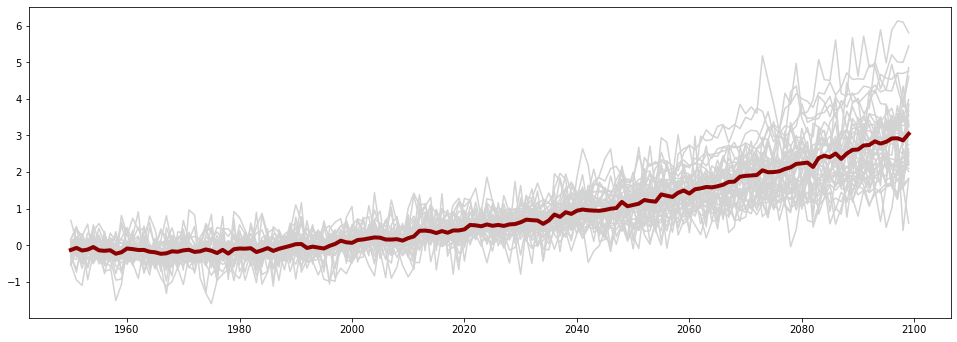

In [8]:
# checking VPD
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.1,0.7,0.8,0.27])

for imodel in np.arange(0,models.size,1):
    ax.plot(vpd_sw_am.year, vpem[imodel,:], color='lightgray')
    
ax.plot(vpd_sw_am.year, np.mean(vpem, axis=0), color='darkred', linewidth=4)

In [9]:
# pick out the periods
year = vpd_sw_am.year
vp_early = vp1mem[ :, (year < 2000)] ; svp_early = svp1mem[:, (year < 2000)]
vp_now = vp1mem[:, (year >= 2000) & (year <= 2020),] ; svp_now = svp1mem[:, (year >=2000) & (year <= 2020) ]
vp_late = vp1mem[:, (year >= 2030) & (year <= 2050) ] ; svp_late = svp1mem[:, (year >= 2030) & (year <= 2050)]
vp_later = vp1mem[:, (year >= 2060) & (year <= 2080) ] ; svp_later = svp1mem[:, (year >=2060) & (year <= 2080)]

In [10]:
# ERA5
data = xr.open_dataset("/project/cas/islas/python_savs/DTF/DATA_SORT/VPD/VPD_ERA5_monthlyfromdaily.nc")
vpd = data.vpd
svp_T = data.svp_T
svp_TD = data.svp_TD

# generate the mask
shpfile="/project/cas/islas/shapefiles/usa/gadm36_USA_1.shp"
masksouthwest = shp.maskgen(shpfile, data, ['California','Nevada','Utah','Arizona','New Mexico','Colorado'])

vpdclim = vpd.groupby('time.month').mean('time')
vpd2020 = vpd.sel(time=slice("2020-01-01","2020-12-31"))

svp_Tclim = svp_T.groupby('time.month').mean('time')
svp_T2020 = svp_T.sel(time=slice("2020-01-01","2020-12-31"))

svp_TDclim = svp_TD.groupby('time.month').mean('time')
svp_TD2020 = svp_TD.sel(time=slice("2020-01-01","2020-12-31"))

vpdmaskd = xr.DataArray(vpd*masksouthwest, coords=vpd.coords)
svp_Tmaskd = xr.DataArray(svp_T*masksouthwest, coords=svp_T.coords)
svp_TDmaskd = xr.DataArray(svp_TD*masksouthwest, coords=svp_TD.coords)

vpd_sw = avg.cosweightlonlat(vpdmaskd, 0, 360, -90,90)
svp_Tsw = avg.cosweightlonlat(svp_Tmaskd, 0, 360, -90, 90)
svp_TDsw = avg.cosweightlonlat(svp_TDmaskd, 0, 360, -90,90)
vpd_sw2020 = vpd_sw[vpd_sw.time.dt.year == 2020]
svp_Tsw2020 = svp_Tsw[svp_Tsw.time.dt.year == 2020]
svp_TDsw2020 = svp_TDsw[svp_TDsw.time.dt.year == 2020]
nyears = vpd_sw.time.size/12
vpd_sw = np.reshape(np.array(vpd_sw), [np.int(nyears),12])
svp_Tsw = np.reshape(np.array(svp_Tsw), [np.int(nyears),12])
svp_TDsw = np.reshape(np.array(svp_TDsw), [np.int(nyears),12])

vpdsw_ERA5 = np.mean(vpd_sw,axis=1) 
svp_Tsw_ERA5 = np.mean(svp_Tsw,axis=1)
svp_TDsw_ERA5 = np.mean(svp_TDsw,axis=1)
vpdsw_ERA5 = vpdsw_ERA5 - np.mean(vpdsw_ERA5)
svp_Tsw_ERA5 = svp_Tsw_ERA5 - np.mean(svp_Tsw_ERA5)
svp_TDsw_ERA5 = svp_TDsw_ERA5 - np.mean(svp_TDsw_ERA5)

masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado


In [11]:
def setupjointpdf( vpdata, svpdata ):
    X, Y = np.mgrid[ -6:6:121j, -6:6:121j ] # probabilities represent per (0.1hPa x 0.1hPa grid box)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    xplot = vpdata.flatten()
    yplot = svpdata.flatten()
    inputdata = np.vstack([xplot, yplot])
    kernel = stats.gaussian_kde(inputdata)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z = np.moveaxis(Z, 1, 0)
    Xout = X[:,0] ; Yout = Y[0,:]
    return Z, Xout, Yout

In [12]:
# set up the color bar for the years
nyears1=2020-1950+1
colors1 = plt.cm.Spectral_r(np.linspace(0.2,1,nyears1+1))
nyears2= 2100-2021+1
colors2 = plt.cm.gnuplot_r(np.linspace(0.55,1,nyears2+1))
yearcolors = np.vstack((colors1,colors2))
yearmap = mpl.colors.ListedColormap(yearcolors)

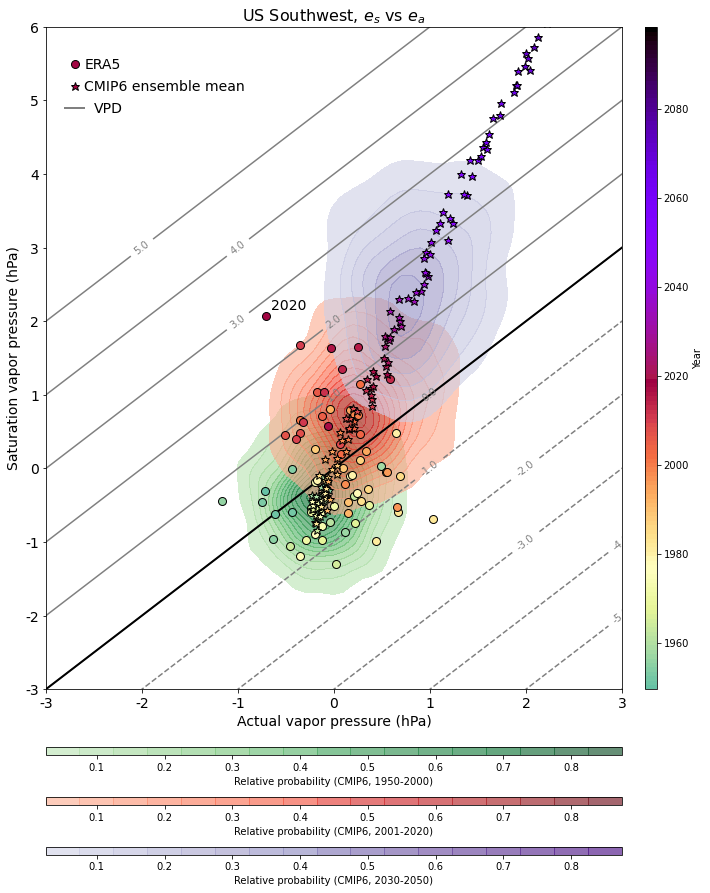

In [49]:
fig = plt.figure(figsize=(16,23))

# vpd contours
x = np.arange(-5,7,1) ; y = np.arange(-5,7,1)
vpdcontours = np.zeros([y.size, x.size])
for ix in np.arange(0,x.size,1):
    vpdcontours[:,ix] = y[:] - x[ix]

# set up the plot axes etc
ax = fig.add_axes([0.1, 0.6, 0.5, 0.4])
ax.set_xlim(-3,3)
ax.set_ylim(-3,6)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_yticks([-3,-2,-1,0,1,2,3,4,5,6])
ax.set_yticklabels(['-3','-2','-1','0','1','2','3','4','5','6'], fontsize=14)
ax.set_ylabel("Saturation vapor pressure (hPa)", fontsize=14)
ax.set_xlabel("Actual vapor pressure (hPa)", fontsize=14)
ax.set_title("US Southwest, $e_{s}$ vs $e_a$", fontsize=16)

# zero VPD anomaly contour
ax.plot(np.arange(-3,4,1),np.arange(-3,4,1), color="black", linewidth=2)

# VPD contours
CS = ax.contour(x, y, vpdcontours, levels=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5], colors='gray')
ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)


# joint pdf for the early period
z, x, y =  setupjointpdf(vp_early, svp_early)
ncontours = (0.9-0.05)/0.05
colors = plt.cm.Greens(np.linspace(0.3,1,np.int(ncontours)+1))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, z, cmap=cmap, levels=np.arange(0.05, 0.9,0.05), alpha=0.6)

ax2 = fig.add_axes([0.1,0.56,0.5,0.005])
clp = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, orientation='horizontal', values = np.arange(0.05,0.9,0.05), 
                                label="Relative probability (CMIP6, 1950-2000)", alpha=0.6)

# joint pdf for 2001-2020
z, x, y = setupjointpdf(vp_now, svp_now)
ncontours = (0.9-0.05)/0.05
colors = plt.cm.Reds(np.linspace(0.3,1,np.int(ncontours)+1))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x,y,z, cmap=cmap, levels=np.arange(0.05, 0.9, 0.05), alpha=0.6)

ax3 = fig.add_axes([0.1,0.53,0.5,0.005])
clp = mpl.colorbar.ColorbarBase(ax3, cmap=cmap, orientation='horizontal', values = np.arange(0.05,0.9,0.05),
                               label="Relative probability (CMIP6, 2001-2020)", alpha=0.6)

# joint pdf for the later period
z, x, y = setupjointpdf(vp_late, svp_late)
ncontours = (0.9-0.05)/0.05
colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, z, cmap=cmap, levels=np.arange(0.05,0.9, 0.05), alpha=0.6)

ax4 = fig.add_axes([0.1,0.5,0.5,0.005])
clp = mpl.colorbar.ColorbarBase(ax4, cmap=cmap, orientation='horizontal', values = np.arange(0.05,0.9,0.05),
                               label="Relative probability (CMIP6, 2030-2050)", alpha=0.6)


# plot ERA5
nyears=2020-1950+1
for iyear in np.arange(0,nyears,1):
    ax.plot(svp_TDsw_ERA5[iyear],svp_Tsw_ERA5[iyear],"o", markerfacecolor=yearcolors[iyear], markersize=8, markeredgecolor='black')
    if (iyear == (nyears-1)):
        ax.text(svp_TDsw_ERA5[iyear]+0.05,svp_Tsw_ERA5[iyear]+0.05,'2020', ha='left', va='bottom', fontsize=14)

# plot CMIP ensemble means
nyears=2099-1950+1
vpemm = np.mean(vpem, axis=0) ; svpemm = np.mean(svpem, axis=0)
for iyear in np.arange(0,nyears,1):
    ax.plot(vpemm[iyear], svpemm[iyear],"*", markerfacecolor=yearcolors[iyear], markersize=9, markeredgecolor="black")

    
# legend
ax.plot(-2.7,5.5,"o",markerfacecolor=yearcolors[70], markersize=8, markeredgecolor='black')
ax.text(-2.6,5.43,'ERA5', fontsize=14)

ax.plot(-2.7, 5.2,"*", markerfacecolor=yearcolors[70], markersize=9, markeredgecolor="black")
ax.text(-2.6,5.13,'CMIP6 ensemble mean', fontsize=14)

ax.plot([-2.8, -2.6],[4.9,4.9],color='gray', linewidth=2)
ax.text(-2.5,4.83,'VPD', fontsize=14)


# color bar for years
ax = fig.add_axes([0.62,0.6,0.01,0.4])
clp = mpl.colorbar.ColorbarBase(ax, cmap = yearmap, orientation='vertical', values=np.arange(1950,2099,1), label="Year")



fig.savefig(plotpath+"cmip6_era5_es_vs_ea.png", bbox_inches="tight", facecolor="white")